In [1]:
import json
import os
import sys
import numpy as np
from gensim.models import Word2Vec
# from keras.preprocessing import sequence
# from keras.layers import merge, Dense, Input,Dropout, Embedding, LSTM, Bidirectional, Activation
# from keras.layers import Conv2D,Conv1D
# from keras.layers.merge import dot, multiply, add, concatenate
# from keras.layers import Merge
# from keras.layers.core import Lambda,Reshape, Flatten, Dropout
# from keras.layers.pooling import GlobalMaxPooling2D, GlobalMaxPooling1D,MaxPooling1D
# from keras.models import Model
# from keras.backend import transpose,batch_dot,expand_dims
# from keras import optimizers
from HomeDepotCSVReader import HomeDepotReader
import Utilities
from DataPreprocessing import DataPreprocessing
from Feature_Word2Vec import Feature_Word2Vec
from AutomaticQueryExpansion import Word2VecQueryExpansion
import re
from nltk.corpus import stopwords
# from keras.utils.np_utils import to_categorical
import pandas as pd
from FeatureEngineering import HomeDepotFeature
# from keras.layers.wrappers import TimeDistributed
# from keras.callbacks import ModelCheckpoint,EarlyStopping

In [2]:
# train_filename = '../data/train_play.csv'
# test_filename = '../data/test_play.csv'
# soln_filename = '../data/solution.csv'
# attribute_filename = '../data/attributes_play.csv'
# description_filename = '../data/product_descriptions_play.csv'
# word2vec_model_path='model/word2vec_play.model'
# doc2vec_model_path='model/doc2vec_play.model'
# vocab_path='model/word2vec_play_vocab.json'
# embeddings_path='model/embeddings_play.npz'

train_filename = '../data/train.csv'
test_filename = '../data/test.csv'
soln_filename = '../data/solution.csv'
attribute_filename = '../data/attributes.csv'
description_filename = '../data/product_descriptions.csv'
word2vec_model_path='model/word2vec_sense2vec.model'
doc2vec_model_path='model/doc2vec_sense2vec_noun.model'
vocab_path='model/doc2vec_sense2vec_vocab_noun.json'
embeddings_path='model/embeddings_sense2vec_noun.npz'
full_features_filename = '../data/features_full.csv'

In [3]:
reader = HomeDepotReader()

train_query_df, product_df, attribute_df, test_query_df = reader.getQueryProductAttributeDataFrame(train_filename,
                                              test_filename,
                                              attribute_filename,
                                              description_filename)
print("train_query_df:",list(train_query_df))
print("product_df:", list(product_df))
print("attribute_df:", list(attribute_df))
print("test_query_df:", list(test_query_df))

#transform attribute into doc
dp = DataPreprocessing()
attribute_doc_df = dp.getAttributeDoc(attribute_df)
#attribute_doc_df
product_df=product_df.join(attribute_doc_df.set_index('product_uid'), on = 'product_uid')
### test data
soln_df = pd.read_csv(soln_filename, delimiter=',', low_memory=False, encoding="ISO-8859-1")
test_private_df = dp.getGoldTestSet(test_query_df, soln_df, testsetoption='Private')#,savepath='../data/test_private_gold.csv')
test_public_df = dp.getGoldTestSet(test_query_df, soln_df, testsetoption='Public')# savepath='../data/test_public_gold.csv')

===========Tranforming labels...
showing current values
trainDF: ['id', 'product_uid', 'search_term', 'relevance']
trainDF:    id  product_uid    search_term  relevance
0   2       100001  angle bracket        3.0
self.mergedLabelDF: ['relevance'] 
 <class 'pandas.core.frame.DataFrame'> (74067, 1)    relevance
0        3.0
Old unique Labels: [ 1.    1.25  1.33  1.5   1.67  1.75  2.    2.25  2.33  2.5   2.67  2.75
  3.  ]
newLabels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Creating new column for training:  relevance_int
===========Transform labels completed
train_query_df: ['id', 'product_uid', 'search_term', 'relevance', 'relevance_int', 'product_idx']
product_df: ['product_title', 'product_uid', 'product_description']
attribute_df: ['product_uid', 'name', 'value']
test_query_df: ['id', 'product_uid', 'search_term', 'product_idx']


In [4]:
product_df

,product_title,product_uid,product_description,attr_json
0,Simpson Strong-Tie 12-Gauge Angle,100001,"Not only do angles make joints stronger, they ...",{'Bullet01': 'Versatile connector for various ...
1,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,BEHR Premium Textured DECKOVER is an innovativ...,"{'Application Method': 'Brush,Roller,Spray', '..."
2,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,Update your bathroom with the Delta Vero Singl...,"{'Bath Faucet Type': 'Combo Tub and Shower', '..."
3,Whirlpool 1.9 cu. ft. Over the Range Convectio...,100006,Achieving delicious results is almost effortle...,"{'Appliance Type': 'Over the Range Microwave',..."
4,Lithonia Lighting Quantum 2-Light Black LED Em...,100007,The Quantum Adjustable 2-Light LED Black Emerg...,"{'Battery Power Type': 'Ni-Cad', 'Battery Size..."
5,House of Fara 3/4 in. x 3 in. x 8 ft. MDF Flut...,100009,Get the House of Fara 3/4 in. x 3 in. x 8 ft. ...,"{'Application': 'Door & Window', 'Bullet01': '..."
6,Valley View Industries Metal Stakes (4-Pack),100010,Valley View Industries Metal Stakes (4-Pack) a...,"{'Attachable': 'No', 'Bullet01': 'Can be used ..."
7,Toro Personal Pace Recycler 22 in. Variable Sp...,100011,Recycler 22 in. Personal Pace Variable Speed S...,"{'Assembled Depth (in.)': '59 in', 'Assembled ..."
8,Hampton Bay Caramel Simple Weave Bamboo Rollup...,100012,The 96 in. wide Caramel Simple Weave Rollup Ba...,"{'Actual Blind/Shade Width (In.)': '96', 'Arch..."
9,InSinkErator SinkTop Switch Single Outlet for ...,100013,The InSinkErator SinkTop Switch Single Outlet ...,"{'Bullet01': 'Kit includes satin nickel, chrom..."


In [5]:
train_query_df,product_df, attribute_df = HomeDepotFeature().getFeature(train_query_df, product_df, attribute_df, test_private_df,
                        features="spelling,nonascii,brand")

Performing spell correction
Performing non-ascii removal
Non-ascii clean on search_term took: 0.01 minutes
Non-ascii clean on product_title took: 0.03 minutes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74067 entries, 0 to 74066
Data columns (total 6 columns):
id               74067 non-null int64
product_uid      74067 non-null int64
search_term      74067 non-null object
relevance        74067 non-null float64
relevance_int    74067 non-null int64
product_idx      74067 non-null object
dtypes: float64(1), int64(3), object(2)
memory usage: 3.4+ MB
train_query_df final column:
 None


In [6]:
product_df

,product_title,product_uid,product_description,attr_json,product_brand
0,Simpson Strong Tie 12 Gauge Angle,100001,Not only do angles make joints stronger they a...,'Bullet01' 'Versatile connector for various 90...,Simpson Strong-Tie
1,BEHR Premium Textured deck over 1 gal SC 141 T...,100002,BEHR Premium Textured deck over is an innovati...,'Application Method' 'Brush Roller Spray' 'Ass...,BEHR Premium Textured DeckOver
2,Delta verso 1 Handle Shower Only Faucet Trim K...,100005,Update your bathroom with the Delta verso Sing...,'Bath Faucet Type' 'Combo Tub and Shower' 'Bui...,Delta
3,Whirlpool 1 9 cu. ft. Over the Range Convectio...,100006,Achieving delicious results is almost effortle...,'Appliance Type' 'Over the Range Microwave' 'A...,Whirlpool
4,lithograph Lighting Quantum 2 Light Black LED ...,100007,The Quantum Adjustable 2 Light LED Black Emerg...,'Battery Power Type' 'Ni Cad' 'Battery Size' '...,Lithonia Lighting
5,House of Fara 3 4 in. x 3 in. x 8 ft. MDF Flut...,100009,Get the House of Fara 3 4 in. x 3 in. x 8 ft. ...,'Application' 'Door Window' 'Bullet01' 'Made o...,House of Fara
6,Valley View Industries Metal Stakes 4 Pack,100010,Valley View Industries Metal Stakes 4 Pack are...,'Attachable' 'No' 'Bullet01' 'Can be used with...,Valley View Industries
7,Toro Personal Pace re cycler 22 in. Variable S...,100011,re cycler 22 in. Personal Pace Variable Speed ...,'Assembled Depth in. ' '59 in' 'Assembled Heig...,Toro
8,Hampton Bay Caramel Simple Weave Bamboo roll u...,100012,The 96 in. wide Caramel Simple Weave roll up B...,'Actual Blind Shade Width In. ' '96' 'Arched' ...,Hampton Bay
9,insinuator sink top Switch Single Outlet for i...,100013,The insinuator sink top Switch Single Outlet f...,'Bullet01' 'Kit includes satin nickel chrome a...,InSinkErator


In [7]:
# ## no attribute
product_df['content'] = product_df['product_title'].map(str) + ". " + \
                        product_df['product_description'].map(str) 
    
    


In [8]:
product_df['content_brand'] = product_df['product_brand']+ ". " + \
                        product_df['product_title'].map(str) + ". " + \
                        product_df['product_description'].map(str)

In [9]:
# attribute
product_df['content_attr'] = product_df['product_brand']+ ". " + \
                       product_df['product_title'].map(str) + ". " + \
                        product_df['product_description'].map(str)  + ". " + \
                        product_df['attr_json'].map(str)

# resample

In [10]:
#resample remove the low classes
resampled_train_query_df = train_query_df[train_query_df.relevance_int == 0]
min_samples=len(resampled_train_query_df)
for i in range(1,13):
    print(i)
    tmp_df = train_query_df[train_query_df.relevance_int == i]
    if len(tmp_df) > min_samples:
        tmp_df = tmp_df.ix[np.random.choice(tmp_df.index,min_samples)]
        resampled_train_query_df=pd.concat([resampled_train_query_df,tmp_df])

    else:
        print("removing {} as too few values {}".format(i,len(tmp_df)))
        
ori_train_query_df=train_query_df        
train_query_df=resampled_train_query_df

1
removing 1 as too few values 4
2
3
removing 3 as too few values 5
4
5
removing 5 as too few values 9
6
7
removing 7 as too few values 11
8
9
removing 9 as too few values 19
10
11
removing 11 as too few values 11
12


In [11]:
#don't sample
#train_query_df=ori_train_query_df


# end resample

In [12]:
import spacy
import re
#import sense2vec

In [13]:
LABELS = {
    'ENT': 'ENT',
    'PERSON': 'ENT',
    'NORP': 'ENT',
    'FAC': 'ENT',
    'ORG': 'ENT',
    'GPE': 'ENT',
    'LOC': 'ENT',
    'LAW': 'ENT',
    'PRODUCT': 'ENT',
    'EVENT': 'ENT',
    'WORK_OF_ART': 'ENT',
    'LANGUAGE': 'ENT',
    'DATE': 'DATE',
    'TIME': 'TIME',
    'PERCENT': 'PERCENT',
    'MONEY': 'MONEY',
    'QUANTITY': 'QUANTITY',
    'ORDINAL': 'ORDINAL',
    'CARDINAL': 'CARDINAL',
}


In [14]:
#pre_format_re = re.compile(r'^[\`\*\~]')
#post_format_re = re.compile(r'[\`\*\~]$')
#url_re = re.compile(r'\[([^]]+)\]\(%%URL\)')
#link_re = re.compile(r'\[([^]]+)\]\(https?://[^\)]+\)')
comma_num_re = re.compile(r'([0-9])(?:,)([0-9])') #Removed commas between digits (for example, 10, 000 was replaced with 10000)
digit_letter_re = re.compile(r'([0-9])([A-Za-z])') #Added dot and space between a digit (left) and a letter (right).
letters_digit_re = re.compile(r'([A-Za-z]){3}([0-9])') #Added space between at least three letters (left) and a digit (right).
letters_slash_re = re.compile(r'([A-Za-z])(?:[\\\/])([A-Za-z])') #Replaced \ or / between letters with a space.
camel_case_re = re.compile(r'([a-z])([A-Z])')
def strip_meta(text,titletext=''):
    #text = link_re.sub(r'\1', text)
    #Concatenation of Numbers with Measure Units
    text = re.sub('(?<=[0-9])[\ ]*pound[s]*(?=\ |$|\.)', '-lb ', text)
    text = re.sub('(?<=[0-9])[\ ]*lb[s]*(?=\ |$|\.)', '-lb ', text)
    text = re.sub('(?<=[0-9])[\ ]*gallon[s]*(?=\ |$|\.)', '-gal ', text)
    text = re.sub('(?<=[0-9])[\ ]*gal(?=\ |$|\.)', '-gal ', text)
    
    text = text.replace('&gt;', '>').replace('&lt;', '<').replace('&nbsp;',' ').\
            replace('&amp;','&').replace(';','.').replace(':','.').\
            replace('+',' ').replace('*','x').replace('(','.').replace(')','.')
    text = comma_num_re.sub(r'\1\2',text)    
    text = digit_letter_re.sub(r'\1. \2',text)    
    text = letters_digit_re.sub(r'\1 \2',text)  
    text = letters_slash_re.sub(r'\1 \2',text)
    if titletext:
        for word in text.split(): 
            #print(word)
            if camel_case_re.findall(word) and word not in titletext.split():  
                word_replace = camel_case_re.sub(r'\1 \2',word)
                text=re.compile(word).sub(word_replace,text)
                #print('here')
    #text = pre_format_re.sub('', text)
    #text = post_format_re.sub('', text)
    return text

In [15]:
strip_meta('asd/sd afj\sjk asasd1100b000 hotDog 10 pounds InSinkErator','InSinkErator asd ads asd')

'asd sd afj sjk asd 1100. b000 hot Dog 10-lb  InSinkErator'

In [16]:
train_query_df['search_term'] = train_query_df['search_term'].map(lambda x: strip_meta(x))
train_query_df['search_term']

17                                    door guards
49                       kitchen cabinet finishes
56                                   mortar tools
217                          paint roller inserts
226                        garage chair organizer
230                                    face masks
242                                plastic covers
270                                 funnel 6 inch
289                               roof leaf broom
290                                  lawn tractor
308                                       colosso
312                               kerosene heater
406                                 celling light
427                       zinc plated flat braces
453                                       pruners
490                               ceiling scraper
493                                         water
513                       garage door parts knobs
604                             tongue and groove
611                             outlet cover bell


In [17]:
product_df['content_brand']=product_df.apply(lambda x: strip_meta(text=x['content_brand'],titletext=x['product_title']),axis=1)
product_df['content_brand']

0         Simpson Strong-Tie. Simpson Strong Tie 12 Gaug...
1         BEHR Premium Textured Deck Over. BEHR Premium ...
2         Delta. Delta verso 1 Handle Shower Only Faucet...
3         Whirlpool. Whirlpool 1 9 cu. ft. Over the Rang...
4         Lithonia Lighting. lithograph Lighting Quantum...
5         House of Fara. House of Fara 3 4 in. x 3 in. x...
6         Valley View Industries. Valley View Industries...
7         Toro. Toro Personal Pace re cycler 22 in. Vari...
8         Hampton Bay. Hampton Bay Caramel Simple Weave ...
9         In Sink Erator. insinuator sink top Switch Sin...
10        Sunjoy. sun joy Calais 8 ft. x 5 ft. x 8 ft. S...
11        MD Building Products. MD Building Products 36 ...
12        House of Fara. House of Fara 8 Linear ft. MDF ...
13        Rain Bird. 1804 Dual Spray Half Pattern 4 in P...
14        Samsung. sam sung 4 2 cu. ft. Front Load Washe...
15        Quikrete. Quikrete 80-lb . Crack Resistant Con...
16        Nantucket Pavers. Nantucket Pa

In [18]:
product_df['content_attr']=product_df.apply(lambda x: strip_meta(text=x['content_attr'],titletext=x['product_title']),axis=1)
product_df['content_attr']

0         Simpson Strong-Tie. Simpson Strong Tie 12 Gaug...
1         BEHR Premium Textured Deck Over. BEHR Premium ...
2         Delta. Delta verso 1 Handle Shower Only Faucet...
3         Whirlpool. Whirlpool 1 9 cu. ft. Over the Rang...
4         Lithonia Lighting. lithograph Lighting Quantum...
5         House of Fara. House of Fara 3 4 in. x 3 in. x...
6         Valley View Industries. Valley View Industries...
7         Toro. Toro Personal Pace re cycler 22 in. Vari...
8         Hampton Bay. Hampton Bay Caramel Simple Weave ...
9         In Sink Erator. insinuator sink top Switch Sin...
10        Sunjoy. sun joy Calais 8 ft. x 5 ft. x 8 ft. S...
11        MD Building Products. MD Building Products 36 ...
12        House of Fara. House of Fara 8 Linear ft. MDF ...
13        Rain Bird. 1804 Dual Spray Half Pattern 4 in P...
14        Samsung. sam sung 4 2 cu. ft. Front Load Washe...
15        Quikrete. Quikrete 80-lb . Crack Resistant Con...
16        Nantucket Pavers. Nantucket Pa

# transform

In [19]:
import spacy
#nlp = spacy.load('en')
#import en_vectors_glove_md
#nlp = en_vectors_glove_md.load()

nlp = spacy.load('en_core_web_md')

In [20]:
sentence='BEHR_Premium_Textured_deck|NOUN over|ADP 1-gal|VERB SC|NOUN 141|CARDINAL Tugboat_Wood|ENT'
keep_tags=['NOUN','PROPN','ENT','NUM','DATE','TIME','PERCENT','MONEY','QUANTITY','ORDINAL','CARDINAL']
#a=re.compile('^(\|'+'|'.join(keep_tags)+')')
keep_tags_re=re.compile('((?:[A-Za-z0-9_]+?\|)(?:NOUN|PROPN|ENT|NUM|DATE|TIME|PERCENT|MONEY|QUANTITY|ORDINAL|CARDINAL))')
print(sentence)
print(' '.join(keep_tags_re.findall(sentence)))

BEHR_Premium_Textured_deck|NOUN over|ADP 1-gal|VERB SC|NOUN 141|CARDINAL Tugboat_Wood|ENT
BEHR_Premium_Textured_deck|NOUN SC|NOUN 141|CARDINAL Tugboat_Wood|ENT


In [21]:
def represent_word(word):
    if word.like_url:
        return '%%URL|X'
    text = re.sub(r'\s', '_', word.text)
    tag = LABELS.get(word.ent_type_, word.pos_)
    if not tag:
        tag = '?'
    return text + '|' + tag

keep_tags_re=re.compile('((?:[A-Za-z0-9_]+?\|)(?:NOUN|PROPN|ENT|NUM|DATE|TIME|PERCENT|MONEY|QUANTITY|ORDINAL|CARDINAL))')
def transform_doc(doc,filter_pos=False):
    for ent in doc.ents:
        ent.merge(ent.root.tag_, ent.text, LABELS[ent.label_])
    for np in doc.noun_chunks:
        while len(np) > 1 and np[0].dep_ not in ('advmod', 'amod', 'compound'):
            np = np[1:]
        np.merge(np.root.tag_, np.text, np.root.ent_type_)
    strings = []
    for sent in doc.sents:
        if sent.text.strip():         
            if filter_pos == True:
                s = ' '.join(represent_word(w) for w in sent if not w.is_space)
                strings.append(' '.join(keep_tags_re.findall(s)))
            else:
                strings.append(' '.join(represent_word(w) for w in sent if not w.is_space))
    if strings:
        return '\n'.join(strings) + '\n'
    else:
        return ''

In [22]:
import time
from Utilities import Utility
#timetracker=Utility()

i=0
for row in product_df.itertuples():
    #timetracker.startTimeTrack()
    #start_time = time.time()
    print(row.content_brand)
    print("=========")
    doc=nlp(row.content_brand)
    print(transform_doc(doc,filter_pos=False))
    i+=1
    #timetracker.checkpointTimeTrack()
    #print("%s s" % round(((time.time() - start_time) ), 2))
    if i > 1:
        break

# product_df['sense2vec_content_attr']=product_df.apply(lambda x: transform_doc(nlp(x['content_attr'])),axis=1)
# product_df['sense2vec_content_attr']

Simpson Strong-Tie. Simpson Strong Tie 12 Gauge Angle. Not only do angles make joints stronger they also provide more consistent straight corners Simpson Strong Tie offers a wide variety of angles in various sizes and thicknesses to handle light duty jobs or projects where a structural connection is needed Some can be bent skewed to match the project For out door projects or those where moisture is present use our ZMAX zinc coated connectors which provide extra resistance against corrosion look for a Z at the end of the model number Versatile connector for various 90 connections and home repair projects stronger than angled nailing or screw fastening alone help ensure joints are consistently straight and strong dimensions 3 in. x 3 in. x 1 1 2 in. Made from 12 Gauge steel galvanized for extra corrosion resistance install with 10. d common nails or 9 x 1 1 2 in. Strong Drive SD screws
Simpson_Strong-Tie|ENT .|PUNCT
Simpson_Strong_Tie|ENT 12|NUM Gauge|PROPN Angle|PROPN .|PUNCT
Not|ADV on

In [23]:
from joblib import Parallel, delayed
import multiprocessing
    
# what are your inputs, and what operation do you want to 
# perform on each input. For example...
def processInput(i):
    return transform_doc(nlp(i),filter_pos=False)

num_cores = multiprocessing.cpu_count()
    
results = Parallel(n_jobs=num_cores)(delayed(processInput)(i.content_brand) for i in product_df.itertuples())

In [24]:
sense2vec_content_brand_df=pd.DataFrame(results,columns=['sense2vec_content_brand'])
product_df=pd.concat([product_df,sense2vec_content_brand_df],axis=1)

In [25]:
product_df['sense2vec_content_brand'][0]

'Simpson_Strong-Tie|ENT .|PUNCT\nSimpson_Strong_Tie|ENT 12|NUM Gauge|PROPN Angle|PROPN .|PUNCT\nNot|ADV only|ADV do|VERB angles|NOUN make|VERB joints|NOUN stronger|ADJ they|PRON also|ADV provide|VERB more_consistent_straight_corners|NOUN Simpson_Strong_Tie|ENT offers|VERB a|DET wide_variety|NOUN of|ADP angles|NOUN in|ADP various_sizes|NOUN and|CCONJ thicknesses|NOUN to|PART handle|VERB light_duty_jobs|NOUN or|CCONJ projects|NOUN where|ADV a|DET structural_connection|NOUN is|VERB needed|VERB Some|DET can|VERB be|VERB bent|VERB skewed|VERB to|PART match|VERB the|DET project|NOUN For|ADP out|ADP door_projects|NOUN or|CCONJ those|DET where|ADV moisture|NOUN is|VERB present_use|NOUN our|ADJ ZMAX|PROPN zinc_coated_connectors|NOUN which|ADJ provide|VERB extra_resistance|NOUN against|ADP corrosion|NOUN look|NOUN for|ADP a|DET Z|NOUN at|ADP the|DET end|NOUN of|ADP the|DET model_number_Versatile_connector|NOUN for|ADP various_90_connections|NOUN and|CCONJ home_repair_projects|NOUN stronger|ADJ t

In [26]:
# product_df['sense2vec_content_brand']=product_df.apply(lambda x: transform_doc(nlp(x['content_brand'])),axis=1)
# product_df['sense2vec_content_brand']

In [27]:
train_query_df['sense2vec_search_term']=train_query_df.apply(lambda x: transform_doc(nlp(x['search_term']),filter_pos=False),axis=1)
train_query_df['sense2vec_search_term']

# results = Parallel(n_jobs=num_cores)(delayed(processInput)(i.search_term) for i in train_query_df.itertuples())
# sense2vec_search_term_df=pd.DataFrame(results,columns=['sense2vec_search_term'])
# train_query_df=pd.concat([train_query_df,sense2vec_search_term_df],axis=1)

17                                      door_guards|NOUN\n
49                    kitchen_cabinet|NOUN finishes|VERB\n
56                                     mortar_tools|NOUN\n
217                       paint_roller|NOUN inserts|VERB\n
226                          garage_chair_organizer|NOUN\n
230                                 face|NOUN masks|VERB\n
242                             plastic|NOUN covers|NOUN\n
270                          funnel|VERB 6_inch|QUANTITY\n
289                                 roof_leaf_broom|NOUN\n
290                                    lawn_tractor|NOUN\n
308                                         colosso|NOUN\n
312                                 kerosene_heater|NOUN\n
406                              celling|VERB light|NOUN\n
427               zinc|NOUN plated|VERB flat_braces|NOUN\n
453                                         pruners|NOUN\n
490                                 ceiling_scraper|NOUN\n
493                                           water|NOUN

In [28]:
train_query_df

,id,product_uid,search_term,relevance,relevance_int,product_idx,sense2vec_search_term
17,69,100017,door guards,1.0,0,"Int64Index([11], dtype='int64')",door_guards|NOUN\n
49,178,100033,kitchen cabinet finishes,1.0,0,"Int64Index([21], dtype='int64')",kitchen_cabinet|NOUN finishes|VERB\n
56,195,100034,mortar tools,1.0,0,"Int64Index([22], dtype='int64')",mortar_tools|NOUN\n
217,696,100119,paint roller inserts,1.0,0,"Int64Index([87], dtype='int64')",paint_roller|NOUN inserts|VERB\n
226,734,100128,garage chair organizer,1.0,0,"Int64Index([93], dtype='int64')",garage_chair_organizer|NOUN\n
230,742,100129,face masks,1.0,0,"Int64Index([94], dtype='int64')",face|NOUN masks|VERB\n
242,764,100134,plastic covers,1.0,0,"Int64Index([99], dtype='int64')",plastic|NOUN covers|NOUN\n
270,867,100149,funnel 6 inch,1.0,0,"Int64Index([109], dtype='int64')",funnel|VERB 6_inch|QUANTITY\n
289,912,100152,roof leaf broom,1.0,0,"Int64Index([112], dtype='int64')",roof_leaf_broom|NOUN\n
290,918,100152,lawn tractor,1.0,0,"Int64Index([112], dtype='int64')",lawn_tractor|NOUN\n


# prep for doc2vec

In [29]:
sentences = []  # Initialize an empty list of sentences
query_sentences = []
doc_sentences = []

print("Parsing sentences from search string")
for query in train_query_df["sense2vec_search_term"]:
    query_sentences += [query.split()]

print("Parsing sentences from unlabeled set")
for doc in product_df['sense2vec_content_brand']:
    doc_sentences += [doc.split()]

sentences = query_sentences+doc_sentences    

Parsing sentences from search string
Parsing sentences from unlabeled set


In [30]:
sentences[0:2]

[['door_guards|NOUN'], ['kitchen_cabinet|NOUN', 'finishes|VERB']]

In [31]:
sentences[-3:-1]

[['unknown_brand_value|NOUN',
  '.|PUNCT',
  'Simpson_Strong_Tie_HB|ENT',
  '3|NUM',
  '1|NUM',
  '2|NUM',
  'x|SYM',
  '14|CARDINAL',
  'in|ADV',
  '.|PUNCT',
  'Top_Flange_I_Joist_Hanger|PROPN',
  '.|PUNCT',
  'Joist_hangers|NOUN',
  'are|VERB',
  'designed|VERB',
  'to|PART',
  'provide|VERB',
  'support|NOUN',
  'underneath|ADP',
  'the|DET',
  'joist_rafter|NOUN',
  'or|CCONJ',
  'beam|NOUN',
  'to|PART',
  'provide|VERB',
  'a|DET',
  'strong|ADJ',
  'a|DET',
  'connection|NOUN',
  'Simpson_Strong_Tie|ENT',
  'offers|VERB',
  'a|DET',
  'diverse_line|NOUN',
  'of|ADP',
  'hangers|NOUN',
  'to|PART',
  'handle|VERB',
  'almost_any_application|NOUN',
  'with|ADP',
  'top_flange|NOUN',
  'concealed|VERB',
  'flange|NOUN',
  'and|CCONJ',
  'field|NOUN',
  'skew|VERB',
  'able|ADJ',
  'and|CCONJ',
  'slope|VERB',
  'able_options_HB_hangers|NOUN',
  'offer|VERB',
  'wide_versatility|NOUN',
  'for|ADP',
  'I|PRON',
  'joists|NOUN',
  'and|CCONJ',
  'structural_composite_lumber_Enhanced_

In [32]:
print(len(sentences))

from gensim.models import doc2vec #word2vec

documents=[]
for i,s in enumerate(sentences):
    if s:
        document={}
        document= doc2vec.LabeledSentence(words=s,tags=['SENT_'+str(i)]) 
        documents+=[document]
print(documents[-1])    

139163
LabeledSentence(['Bosch|ENT', '.|PUNCT', 'Bosch|ENT', '4|CARDINAL', 'in|ADP', '.|PUNCT', 'Bi_Metal_Hole_Saw|ENT', '.|PUNCT', 'The|DET', 'Bosch|ENT', 'quick_change|NOUN', 'bi|ADP', 'metal_hole_saws|NOUN', 'feature|VERB', 'progress|NOUN', 'or|CCONJ', 'tooth_geometry|NOUN', 'combining|VERB', 'cutting|VERB', 'teeth|NOUN', 'with|ADP', 'specially_designed_chip_removal_teeth|NOUN', 'for|ADP', 'super|ADJ', 'fast|ADV', 'cutting|VERB', 'action|NOUN', 'in|ADP', 'metal|NOUN', 'and|CCONJ', 'wood|NOUN', 'They|PRON', 'work|VERB', 'with|ADP', 'mandrel_models|NOUN', 'HSBAM_M|ENT', '38|NUM', 'M|PROPN', '12|NUM', 'and|CCONJ', 'PCMSDSPL_Hole|ENT', 'saws|NOUN', '1_1_2|DATE', 'in|ADP', '.|PUNCT', 'and|CCONJ', 'larger|ADJ', 'can|VERB', 'also|ADV', 'be|VERB', 'used|VERB', 'with|ADP', 'mandrel_model_HSBAMP_progress|NOUN', 'or|CCONJ', 'tooth_design|NOUN', 'for|ADP', 'faster|ADV', 'cutting|VERB', 'and|CCONJ', 'longer|ADJ', 'life|NOUN', 'reinforced_shoulder|NOUN', 'for|ADP', 'increased_strenh|NOUN', '8|CAR

In [33]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 100#50#300    # Word vector dimensionality                      
min_word_count = 1#5#40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 10e-5 #0 #1e-3   # Downsample setting for frequent words

#https://github.com/jhlau/doc2vec hyperparam guide

# Initialize and train the model (this will take some time)
from gensim.models import doc2vec #word2vec
print("Training model...")
# doc2vec_model = doc2vec.Doc2Vec(documents, workers=num_workers, \
#             size=num_features, min_count = min_word_count, \
#             window = context, sample = downsampling,iter=20)

# doc2vec_model = doc2vec.Doc2Vec(documents, size=300, min_count=5, window=5, \
#                             iter=30, workers=4, alpha=0.1, min_alpha=0.0001,
#                         dm_concat=1, dm=0, negative=5)

# 20:43 run
# doc2vec_model = doc2vec.Doc2Vec(documents, size=100, min_count=0, window=8, \
#                             iter=20, workers=4, #alpha=0.1, min_alpha=0.0001,
#                             dm_concat=1, dm=0,sample = 0,  negative=5,dbow_words=1)  

# # 20:57 run
# doc2vec_model = doc2vec.Doc2Vec(documents, size=100, min_count=0, window=16, \
#                             iter=20, workers=4, #alpha=0.1, min_alpha=0.0001,
#                             dm_concat=1, dm=0,sample = downsampling,  negative=5,dbow_words=1)  

#New
doc2vec_model = doc2vec.Doc2Vec(documents, size=200, min_count=1, window=10, \
                            iter=30, workers=4, #alpha=0.1, min_alpha=0.0001,
                            sample = downsampling,  negative=5,dbow_words=1,
                               dm_mean=0, dm_concat=1, dm=1,)  

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
doc2vec_model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
#model_name = "300features_40minwords_10context"
doc2vec_model.save(doc2vec_model_path)

2017-04-09 03:26:11,551 : INFO : collecting all words and their counts
2017-04-09 03:26:11,552 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-04-09 03:26:11,603 : INFO : PROGRESS: at example #10000, processed 21773 words (427935/s), 6611 word types, 10000 tags


Training model...


2017-04-09 03:26:11,835 : INFO : PROGRESS: at example #20000, processed 704932 words (2966830/s), 99665 word types, 20000 tags
2017-04-09 03:26:12,207 : INFO : PROGRESS: at example #30000, processed 1935061 words (3308937/s), 208313 word types, 30000 tags
2017-04-09 03:26:12,576 : INFO : PROGRESS: at example #40000, processed 3153756 words (3311777/s), 293149 word types, 40000 tags
2017-04-09 03:26:12,959 : INFO : PROGRESS: at example #50000, processed 4347214 words (3122049/s), 364277 word types, 50000 tags
2017-04-09 03:26:13,330 : INFO : PROGRESS: at example #60000, processed 5552477 words (3261845/s), 432428 word types, 60000 tags
2017-04-09 03:26:13,699 : INFO : PROGRESS: at example #70000, processed 6742409 words (3231899/s), 489505 word types, 70000 tags
2017-04-09 03:26:14,062 : INFO : PROGRESS: at example #80000, processed 7907600 words (3212218/s), 552634 word types, 80000 tags
2017-04-09 03:26:14,432 : INFO : PROGRESS: at example #90000, processed 9079671 words (3175696/s), 

In [34]:
print(len(doc2vec_model.wv.vocab))
doc2vec_model.wv.vocab

835706


{'door_guards|NOUN': <gensim.models.keyedvectors.Vocab at 0x7fbb3a80d668>,
 'kitchen_cabinet|NOUN': <gensim.models.keyedvectors.Vocab at 0x7fbaf4da8a90>,
 'finishes|VERB': <gensim.models.keyedvectors.Vocab at 0x7fbaa4736b00>,
 'mortar_tools|NOUN': <gensim.models.keyedvectors.Vocab at 0x7fbaa4736ba8>,
 'paint_roller|NOUN': <gensim.models.keyedvectors.Vocab at 0x7fbaa47368d0>,
 'inserts|VERB': <gensim.models.keyedvectors.Vocab at 0x7fbaa4736a58>,
 'garage_chair_organizer|NOUN': <gensim.models.keyedvectors.Vocab at 0x7fbaa4736860>,
 'face|NOUN': <gensim.models.keyedvectors.Vocab at 0x7fbaa4736b38>,
 'masks|VERB': <gensim.models.keyedvectors.Vocab at 0x7fbaa4736b70>,
 'plastic|NOUN': <gensim.models.keyedvectors.Vocab at 0x7fbaa4736a90>,
 'covers|NOUN': <gensim.models.keyedvectors.Vocab at 0x7fbaa4736978>,
 'funnel|VERB': <gensim.models.keyedvectors.Vocab at 0x7fbaa47364e0>,
 '6_inch|QUANTITY': <gensim.models.keyedvectors.Vocab at 0x7fbaa47369b0>,
 'roof_leaf_broom|NOUN': <gensim.models.key

In [35]:
vocab_words=[k for k,v in doc2vec_model.wv.vocab.items()]

In [36]:
train_query_df.iloc[0]

id                                                    69
product_uid                                       100017
search_term                                  door guards
relevance                                              1
relevance_int                                          0
product_idx              Int64Index([11], dtype='int64')
sense2vec_search_term                 door_guards|NOUN\n
Name: 17, dtype: object

In [37]:
r = re.compile("r_emote\|",flags=re.IGNORECASE)
newlist = filter(r.match, vocab_words)
print(list(newlist))

['r_emote|NOUN']


In [38]:
print(doc2vec_model.most_similar('r_emote|NOUN', [], 3))

[('timer|NOUN', 0.45513880252838135), ('magnificent_unit|NOUN', 0.4400516152381897), ('r_emote_control|NOUN', 0.4345439672470093)]


In [39]:
print(doc2vec_model.docvecs.most_similar( [ doc2vec_model['r_emote|NOUN'] ] ))

2017-04-09 04:46:14,214 : INFO : precomputing L2-norms of doc weight vectors


[('SENT_22133', 0.3131977617740631), ('SENT_86426', 0.2936478853225708), ('SENT_54071', 0.28807154297828674), ('SENT_130861', 0.2843253016471863), ('SENT_25011', 0.2838953137397766), ('SENT_101775', 0.28374677896499634), ('SENT_63834', 0.2752860486507416), ('SENT_32894', 0.2738480567932129), ('SENT_136745', 0.2706984281539917), ('SENT_42683', 0.2682388126850128)]


In [40]:
print(sentences[0])
print(sentences[len(train_query_df)])

['door_guards|NOUN']
['Simpson_Strong-Tie|ENT', '.|PUNCT', 'Simpson_Strong_Tie|ENT', '12|NUM', 'Gauge|PROPN', 'Angle|PROPN', '.|PUNCT', 'Not|ADV', 'only|ADV', 'do|VERB', 'angles|NOUN', 'make|VERB', 'joints|NOUN', 'stronger|ADJ', 'they|PRON', 'also|ADV', 'provide|VERB', 'more_consistent_straight_corners|NOUN', 'Simpson_Strong_Tie|ENT', 'offers|VERB', 'a|DET', 'wide_variety|NOUN', 'of|ADP', 'angles|NOUN', 'in|ADP', 'various_sizes|NOUN', 'and|CCONJ', 'thicknesses|NOUN', 'to|PART', 'handle|VERB', 'light_duty_jobs|NOUN', 'or|CCONJ', 'projects|NOUN', 'where|ADV', 'a|DET', 'structural_connection|NOUN', 'is|VERB', 'needed|VERB', 'Some|DET', 'can|VERB', 'be|VERB', 'bent|VERB', 'skewed|VERB', 'to|PART', 'match|VERB', 'the|DET', 'project|NOUN', 'For|ADP', 'out|ADP', 'door_projects|NOUN', 'or|CCONJ', 'those|DET', 'where|ADV', 'moisture|NOUN', 'is|VERB', 'present_use|NOUN', 'our|ADJ', 'ZMAX|PROPN', 'zinc_coated_connectors|NOUN', 'which|ADJ', 'provide|VERB', 'extra_resistance|NOUN', 'against|ADP', '

In [41]:
doc2vec_model.docvecs.most_similar(['SENT_0'])

[('SENT_104364', 0.34025391936302185),
 ('SENT_139021', 0.28663715720176697),
 ('SENT_106665', 0.2693845331668854),
 ('SENT_85524', 0.26811784505844116),
 ('SENT_120228', 0.26657989621162415),
 ('SENT_111682', 0.2623198330402374),
 ('SENT_98882', 0.25945907831192017),
 ('SENT_67016', 0.2593371272087097),
 ('SENT_126903', 0.2546427547931671),
 ('SENT_24064', 0.25384795665740967)]

In [42]:
print(sentences[74067])

['unknown_brand_value|ADJ', '.|PUNCT', 'Rust_Oleum_Specialty|ENT', '11|NUM', 'oz|INTJ', '.|PUNCT', 'Clear_Matte_Spray|PROPN', '.|PUNCT', 'Matte_Finish|ENT', 'is|VERB', 'a|DET', 'clear_protective_spray|NOUN', 'that|ADJ', 'eliminates|VERB', 'glossiness|NOUN', 'and|CCONJ', 'glare|NOUN', 'It|PRON', 'provides|VERB', 'a|DET', 'protective_finish|NOUN', 'for|ADP', 'your|ADJ', 'art|NOUN', 'or|CCONJ', 'decorative_projects|NOUN', 'Great|VERB', 'for|ADP', 'wood|NOUN', 'metal|NOUN', 'wicker|NOUN', 'plastic_glass_plaster|NOUN', 'and|CCONJ', 'paper|NOUN', 'Should|VERB', 'be|VERB', 'applied|VERB', 'for|ADP', 'indoor_use|NOUN', 'only_California_residents|NOUN', 'see|VERB', 'nbsp_Proposition_65_information|NOUN', 'this|DET', 'topcoats|VERB', 'protects|VERB', 'as|ADP', 'it|PRON', 'eliminates|VERB', 'gloss|NOUN', 'and|CCONJ', 'glare|NOUN', 'spray|NOUN', 'any|DET', 'angle|NOUN', 'and|CCONJ', 'comfort_tip|NOUN', 'for|ADP', 'easy_application|NOUN', 'dries|NOUN', 'to|PART', 'touch|VERB', 'in|ADP', '5|CARDINAL

In [43]:
#doc2vec_model.docvecs.similarity('SENT_17','SENT_74068')
doc2vec_model.docvecs.similarity(0,74067+11)

0.14498383153572475

In [44]:

len(train_query_df)

14735

In [45]:
train_query_df

,id,product_uid,search_term,relevance,relevance_int,product_idx,sense2vec_search_term
17,69,100017,door guards,1.0,0,"Int64Index([11], dtype='int64')",door_guards|NOUN\n
49,178,100033,kitchen cabinet finishes,1.0,0,"Int64Index([21], dtype='int64')",kitchen_cabinet|NOUN finishes|VERB\n
56,195,100034,mortar tools,1.0,0,"Int64Index([22], dtype='int64')",mortar_tools|NOUN\n
217,696,100119,paint roller inserts,1.0,0,"Int64Index([87], dtype='int64')",paint_roller|NOUN inserts|VERB\n
226,734,100128,garage chair organizer,1.0,0,"Int64Index([93], dtype='int64')",garage_chair_organizer|NOUN\n
230,742,100129,face masks,1.0,0,"Int64Index([94], dtype='int64')",face|NOUN masks|VERB\n
242,764,100134,plastic covers,1.0,0,"Int64Index([99], dtype='int64')",plastic|NOUN covers|NOUN\n
270,867,100149,funnel 6 inch,1.0,0,"Int64Index([109], dtype='int64')",funnel|VERB 6_inch|QUANTITY\n
289,912,100152,roof leaf broom,1.0,0,"Int64Index([112], dtype='int64')",roof_leaf_broom|NOUN\n
290,918,100152,lawn tractor,1.0,0,"Int64Index([112], dtype='int64')",lawn_tractor|NOUN\n


In [46]:
from sklearn.metrics.pairwise import cosine_similarity

i=0
similarity_scores=[]
relevance_scores=[]
for query_row in train_query_df.itertuples():    
    query=nlp(str(query_row.search_term)) 
    relevance=query_row.relevance
    product_uid=int(query_row.product_uid)
    #product_idx=query_row.product_idx.values[0]
    product_idx=product_df[product_df['product_uid'] == product_uid]['content_attr'].index[0] #feature_df workaround
    
    ## similarity doc
    similarity_score = doc2vec_model.docvecs.similarity(i,int(len(train_query_df)+product_idx))
    
    ### cosine
#     similarity_score=0
#     for word in query_row.sense2vec_search_term.split():
#         #print(word)
#         #print(doc2vec_model[word].reshape(-1,1).T.shape)
#         #print(doc2vec_model.docvecs[int(len(train_query_df)+product_idx)].reshape(-1,1).T.shape)
#         similarity_score += np.squeeze(cosine_similarity(doc2vec_model[word].reshape(-1,1).T,\
#                           doc2vec_model.docvecs[int(len(train_query_df)+product_idx)].reshape(-1,1).T))
# #         print(np.squeeze(cosine_similarity(doc2vec_model[word].reshape(-1,1).T,\
# #                          doc2vec_model.docvecs[int(len(train_query_df)+product_idx)].reshape(-1,1).T)))
# #       print(similarity_score)

    ### end cosine
    
    similarity_scores+=[similarity_score]
    relevance_scores+=[relevance]
    
    i+=1
    if i % 1000 == 0: #print every 100 
        print(i)
#     if i >= 10:
#         break
#     else:
#         print(relevance,similarity_score)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


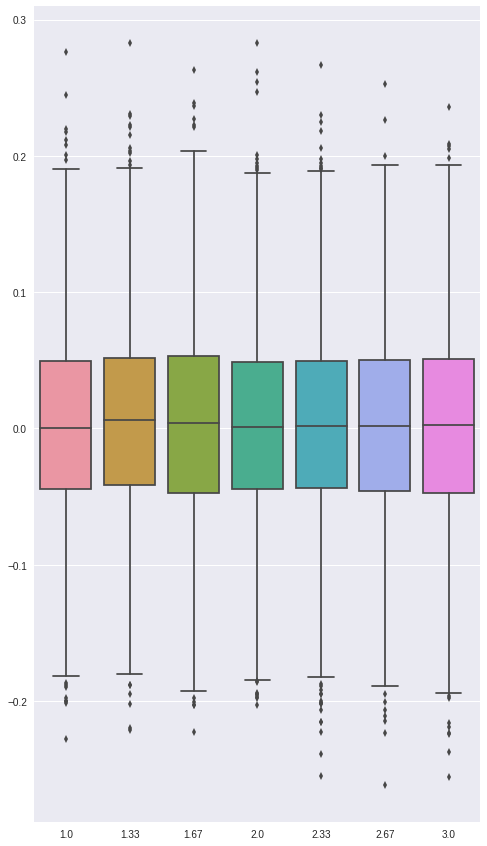

In [48]:
fig = plt.gcf()
fig.set_size_inches(8,15)
#sns.stripplot(relevance_scores,similarity_scores,jitter=True, alpha=.40)
#sns.pointplot(relevances,overlap_ratios,jitter=True, alpha=.40)
sns.boxplot(relevance_scores,similarity_scores)

#sns.despine()

In [49]:
# from gensim.models.word2vec import Word2Vec
# from gensim.models.word2vec import KeyedVectors
# word2vec_model = Word2Vec.load('/home/ongmin/PycharmProjects/IRDM2017/data/models/prod_content_model')


In [50]:
#word2vec_model.wv.vocab

In [51]:
print(doc2vec_model.most_similar('Whirlpool|ENT', [], 3))

[('Amana|ENT', 0.5817813873291016), ('kitchenaid|VERB', 0.5167223215103149), ('tag|VERB', 0.5062089562416077)]


In [52]:
print(doc2vec_model.most_similar('wood|NOUN', [], 3))

[('birch|NOUN', 0.519379198551178), ('surfacing|NOUN', 0.47012564539909363), ('metal_wood|NOUN', 0.45125192403793335)]


In [53]:
print(doc2vec_model.most_similar('kitchen|NOUN', [], 3))

[('bathroom|NOUN', 0.5322508811950684), ('existing_laminate_kitchen|NOUN', 0.47621655464172363), ('bedroom|NOUN', 0.46729740500450134)]


In [54]:
print(doc2vec_model.most_similar('shower|NOUN', [], 3))

[('shower|VERB', 0.6033557653427124), ('tub|NOUN', 0.5566350221633911), ('shower_head|NOUN', 0.5176994800567627)]


In [55]:
print(doc2vec_model.most_similar('steel|NOUN', [], 10))

[('stainless|ADJ', 0.5705153942108154), ('RNCPVC|PROPN', 0.502705454826355), ('steel_jets|NOUN', 0.4906122088432312), ('faultless_elements|NOUN', 0.4884803891181946), ('malleable_iron_construction_maximum_working_pressure|NOUN', 0.47728782892227173), ('steel|VERB', 0.4748472273349762), ('stainless|NOUN', 0.47387227416038513), ('Steel|ENT', 0.4715394675731659), ('polycarbonate|ADJ', 0.47149813175201416), ('plastic_sheet_coil|NOUN', 0.4670044183731079)]


In [56]:
print(doc2vec_model.most_similar('microwave|NOUN', [], 10))

[('oven|NOUN', 0.49766820669174194), ('cook|NOUN', 0.42205095291137695), ('hood|NOUN', 0.40578675270080566), ('Kelston_collection_front_overflow|NOUN', 0.378734290599823), ('oven|ADV', 0.37472617626190186), ('cook_top|NOUN', 0.37391188740730286), ('mixer|NOUN', 0.3733903169631958), ('Ortho|ENT', 0.37262725830078125), ('microwave_oven|NOUN', 0.3613232672214508), ('lowest_sound_rating|NOUN', 0.35868608951568604)]


In [57]:
print(doc2vec_model.most_similar('LED|NOUN', [], 10))

[('LED|ENT', 0.6217404007911682), ('chromotherapy|NOUN', 0.4845695495605469), ('LED|PROPN', 0.4645298719406128), ('fluorescent|NOUN', 0.4559912383556366), ('soft_accent|NOUN', 0.44623318314552307), ('light_therapy_system|NOUN', 0.4378436803817749), ('combined_audible_and_visual_alarm|NOUN', 0.4350197911262512), ('infrared|ADJ', 0.4243106544017792), ('led|VERB', 0.4238142967224121), ('exotic_flowers|NOUN', 0.42097780108451843)]


In [58]:
words=[k for k,v in word2vec_model.wv.vocab.items()]

NameError: name 'word2vec_model' is not defined

In [ ]:
r = re.compile("stool\|",flags=re.IGNORECASE)
newlist = filter(r.match, words)
print(list(newlist))

In [ ]:
for word in list(filter(r.match, words)):
    #print(str(word))
    print(word,word2vec_model.most_similar(word, [], 3))

In [ ]:
nlp = spacy.load('en')
nlp.vocab.load_vectors("/home/ongmin/PycharmProjects/IRDM2017/data/models/prod_content_model")

In [ ]:
from sense2vec.vectors import VectorMap
vector_map = VectorMap(300)
a=vector_map.load('/home/ongmin/PycharmProjects/IRDM2017/data/models/')

In [ ]:
model = sense2vec.load('/home/ongmin/PycharmProjects/IRDM2017/data/models/prod_content_model')